In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

import lightgbm as lgb
from scipy.stats import uniform, randint
from catboost import CatBoostRegressor
import xgboost as xgb

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
df_sub = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

In [3]:
print(f"Train shape {df.shape}")
print(f"Test shape {df_test.shape}")

Train shape (517754, 14)
Test shape (172585, 13)


In [4]:
df.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [5]:
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df_test.isna().sum().sum()

np.int64(0)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [10]:
df=df.drop("id", axis=1)
df_test=df_test.drop("id", axis=1)

In [11]:
num_cols = df.select_dtypes(include = "number").columns.tolist()
cat_cols = df.select_dtypes(exclude = "number").columns.tolist()
num_cols.remove("accident_risk")

print(f"categorical columns : {cat_cols}")
print(f"numerical columns : {num_cols}")

categorical columns : ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
numerical columns : ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


In [12]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0


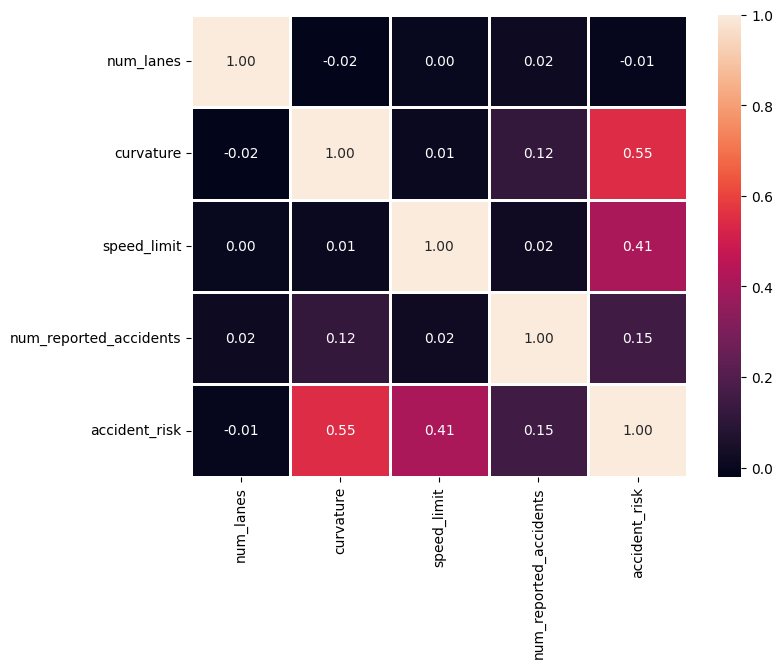

In [13]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[num_cols + ['accident_risk']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, color="blue")
plt.show()

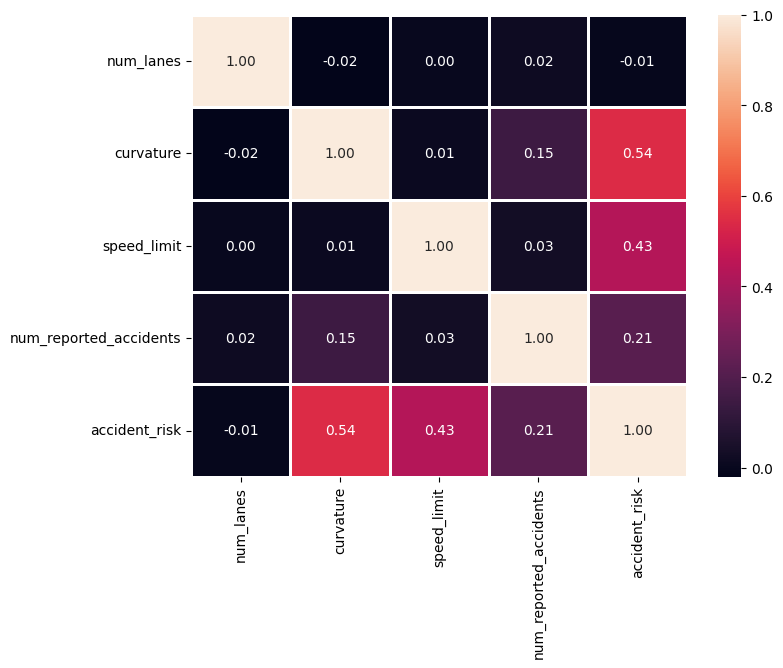

In [14]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[num_cols + ['accident_risk']].corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, color="blue")
plt.show()

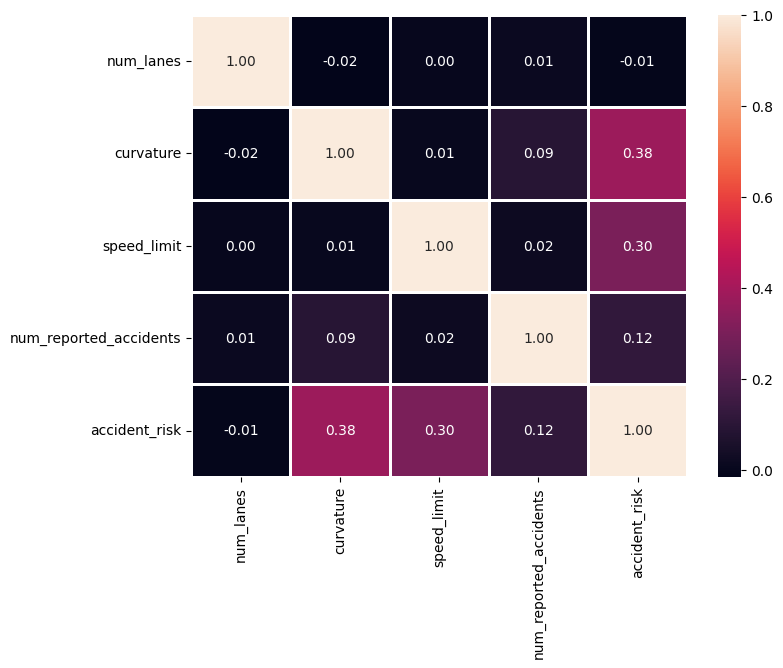

In [15]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[num_cols + ['accident_risk']].corr(method='kendall')
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, color="blue")
plt.show()

In [16]:
for c in cat_cols:
    print(f" {c} (Uniques): {df[c].unique()}")

 road_type (Uniques): ['urban' 'rural' 'highway']
 lighting (Uniques): ['daylight' 'dim' 'night']
 weather (Uniques): ['rainy' 'clear' 'foggy']
 road_signs_present (Uniques): [False  True]
 public_road (Uniques): [ True False]
 time_of_day (Uniques): ['afternoon' 'evening' 'morning']
 holiday (Uniques): [False  True]
 school_season (Uniques): [ True False]


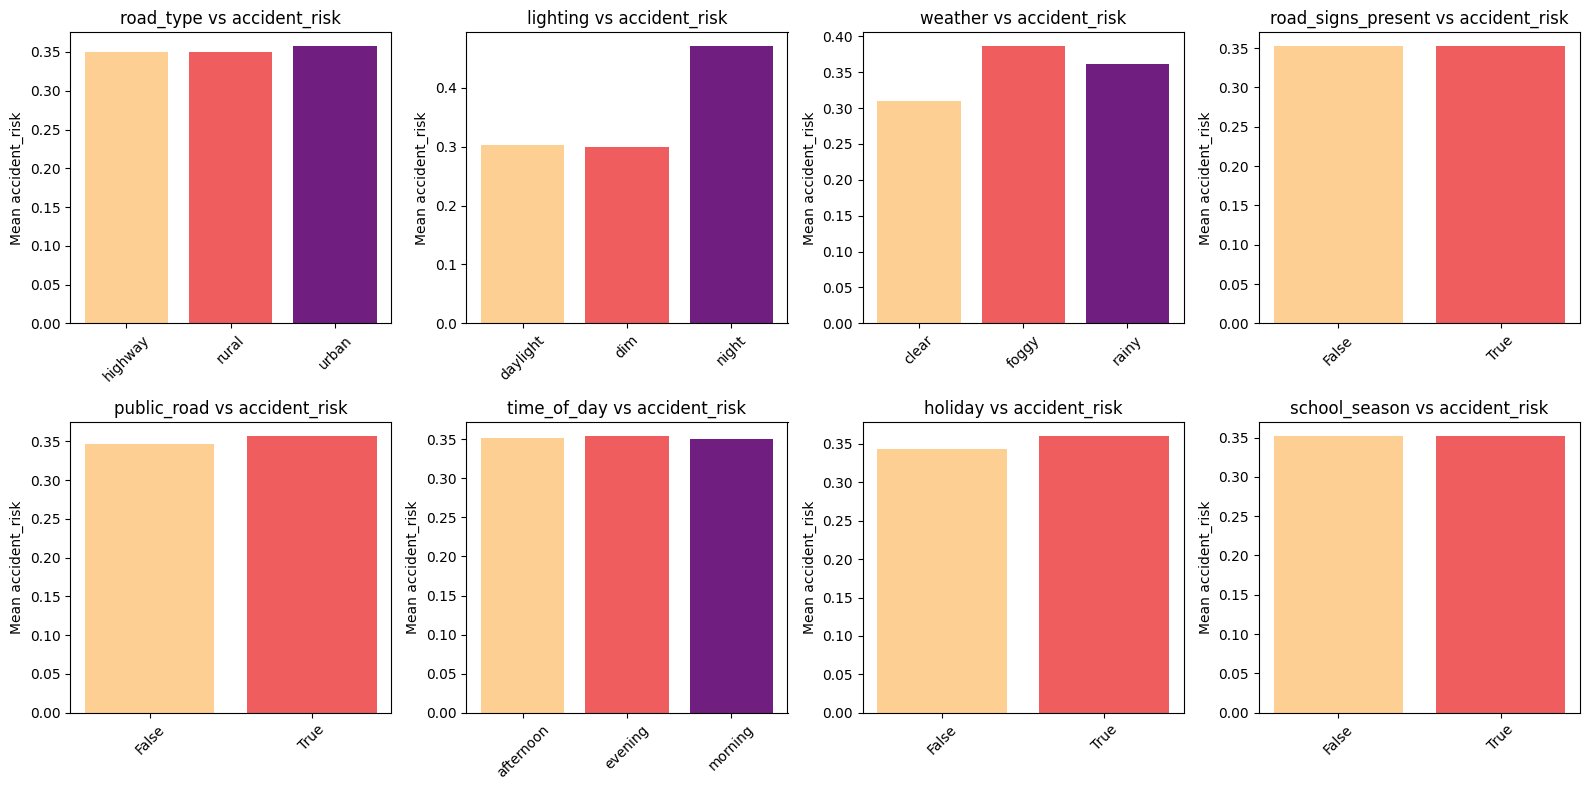

In [17]:
# Categorical features vs target

fig , axes = plt.subplots(2,4, figsize=(16,8))
axes = axes.flatten()
cmap = plt.get_cmap('magma')
colors = cmap([0.9,0.66,0.33])
target = 'accident_risk'
for i,col in enumerate(cat_cols) :
  
    grouped = df.groupby(col)[target].mean()
   
    axes[i].bar(grouped.index.astype(str), grouped.values , color=colors)  # .astype(str) to handle non-string indices
    
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_title(f'{col} vs {target}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

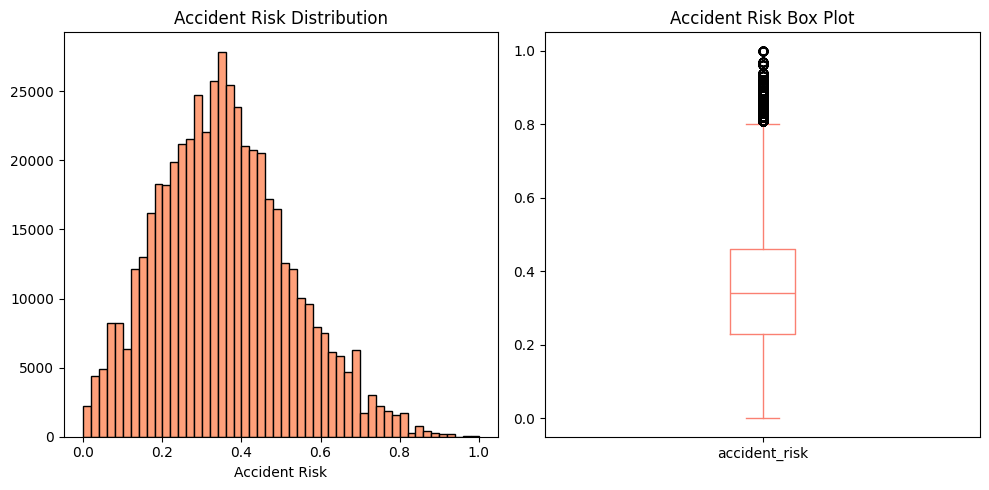

In [18]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.hist(df['accident_risk'], bins = 50, edgecolor = 'black', color = 'lightsalmon')
plt.title('Accident Risk Distribution')
plt.xlabel('Accident Risk')

plt.subplot(1, 2, 2)
df['accident_risk'].plot(kind='box', color='salmon')
plt.title('Accident Risk Box Plot')
plt.tight_layout()
plt.show()

In [19]:
df['weather_lighting'] = df['weather'].astype(str) + '_' + df['lighting'].astype(str)
df_test['weather_lighting'] = df_test['weather'].astype(str) + '_' + df_test['lighting'].astype(str)

df['speed_squared'] = df['speed_limit'] ** 2
df_test['speed_squared'] = df_test['speed_limit'] ** 2

df['curvature_squared'] = df['curvature'] ** 2
df_test['curvature_squared'] = df_test['curvature'] ** 2

df['meta_curvature'] = 0.3 * df['curvature']
df['meta_night'] = 0.2 * (df['lighting'] == 'night').astype(int)
df['meta_weather'] = 0.1 * (df['weather'] != 'clear').astype(int)
df['meta_speed'] = 0.2 * (df['speed_limit'] >= 60).astype(int)
df['meta_accidents'] = 0.1 * (df['num_reported_accidents'] > 2).astype(int)

df_test['meta_curvature'] = 0.3 * df_test['curvature']
df_test['meta_night'] = 0.2 * (df_test['lighting'] == 'night').astype(int)
df_test['meta_weather'] = 0.1 * (df_test['weather'] != 'clear').astype(int)
df_test['meta_speed'] = 0.2 * (df_test['speed_limit'] >= 60).astype(int)
df_test['meta_accidents'] = 0.1 * (df_test['num_reported_accidents'] > 2).astype(int)

In [20]:
def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)


    
df['meta'] = f(df)
df_test['meta'] = f(df_test)

In [21]:
df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,...,accident_risk,weather_lighting,speed_squared,curvature_squared,meta_curvature,meta_night,meta_weather,meta_speed,meta_accidents,meta
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,...,0.13,rainy_daylight,1225,0.0036,0.018,0.0,0.1,0.0,0.0,0.118
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,...,0.35,clear_daylight,1225,0.9801,0.297,0.0,0.0,0.0,0.0,0.297
2,rural,4,0.63,70,dim,clear,False,True,morning,True,...,0.30,clear_dim,4900,0.3969,0.189,0.0,0.0,0.2,0.0,0.389
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,...,0.21,rainy_dim,1225,0.0049,0.021,0.0,0.1,0.0,0.0,0.121
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,...,0.56,foggy_daylight,3600,0.3364,0.174,0.0,0.1,0.2,0.0,0.474


In [22]:
bool_cols = ["road_signs_present", "public_road","holiday", "school_season"]
for col in bool_cols :
    df[col]= df[col].astype(int)
    df_test[col]=df_test[col].astype(int)

In [23]:
le = LabelEncoder()
cate_cols = df.select_dtypes(exclude = "number").columns.tolist()
for col in cate_cols:
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.fit_transform(df_test[col])

In [24]:
df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,...,accident_risk,weather_lighting,speed_squared,curvature_squared,meta_curvature,meta_night,meta_weather,meta_speed,meta_accidents,meta
0,2,2,0.06,35,0,2,0,1,0,0,...,0.13,6,1225,0.0036,0.018,0.0,0.1,0.0,0.0,0.118
1,2,4,0.99,35,0,0,1,0,1,1,...,0.35,0,1225,0.9801,0.297,0.0,0.0,0.0,0.0,0.297
2,1,4,0.63,70,1,0,0,1,2,1,...,0.30,1,4900,0.3969,0.189,0.0,0.0,0.2,0.0,0.389
3,0,4,0.07,35,1,2,1,1,2,0,...,0.21,7,1225,0.0049,0.021,0.0,0.1,0.0,0.0,0.121
4,1,1,0.58,60,0,1,0,0,1,1,...,0.56,3,3600,0.3364,0.174,0.0,0.1,0.2,0.0,0.474


In [25]:
print("Train Shape :" , df.shape)
print("Test Shape :" , df_test.shape)

Train Shape : (517754, 22)
Test Shape : (172585, 21)


In [26]:
X_train = df.drop('accident_risk', axis = 1)
y_train = df['accident_risk']
X_test = df_test

In [27]:
# Lighgbm best param from random search cv
param_lgb = {
    
    'n_estimators': 2700,
    'learning_rate': 0.01,
    'num_leaves': 99,
    'max_depth': 13,
    'min_child_samples': 10,
    'min_child_weight': 0.002,
    'subsample': 0.60,
    'subsample_freq': 1,
    'colsample_bytree': 0.83,
    'reg_alpha': 0.01,
    'reg_lambda':  0.70,
    'min_split_gain':  0.004,
    'feature_fraction': 0.9 , 

 
}

# catboost best param from random search cv
param_cat = {
     'bagging_temperature' : 0.20,
     'border_count'        : 178,
     'depth'               : 8,
     'iterations'          : 1600,
     'l2_leaf_reg'         : 4,
     'learning_rate'       : 0.04,
     'random_strength'    : 0.32,
     
}

# xgboost best param from random search cv
param_xgb = {
              'n_estimators': 1251,
              'learning_rate': 0.0074,
              'max_depth': 9,
              'min_child_weight': 3,
              'subsample': 0.72,
              'colsample_bytree': 0.74,
              'colsample_bylevel': 0.94,
              'gamma': 0.0002,
              'reg_alpha': 0.61,
              'reg_lambda': 4.92}


print("\n" + "="*60)
print("Simple Average (90-10)")
print("="*60)

cat_model =  CatBoostRegressor(**param_cat,
                               loss_function='RMSE',
                               random_seed=42,
                               verbose=False,
                               thread_count=-1,)

lgb_model = lgb.LGBMRegressor(**param_lgb ,
                               objective='regression',
                               metric='rmse',
                               boosting_type='gbdt',
                               random_state=42,
                               n_jobs=-1,
                               verbose=-1    
                            )  

xgb_model = xgb.XGBRegressor(**param_xgb,
                              random_state = 42,
                              objective = 'reg:squarederror')

#Lets see CV Score
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    
    # Train cat
    cat_model.fit(X_tr, y_tr)
    cat_pred = cat_model.predict(X_val)
    
    # Train LightGBM
    lgb_model.fit(X_tr, y_tr)
    lgb_pred = lgb_model.predict(X_val)

    # Train XGBoost
    xgb_model.fit(X_tr, y_tr)
    xgb_pred = xgb_model.predict(X_val)
    # Simple average
    ensemble_pred = 0.3  * cat_pred + 0.3 * lgb_pred + 0.4 * xgb_pred
    # Simple average
       
    rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
    cv_scores.append(rmse)
    print(f"Fold {fold}: {rmse:.5f}")

simple_avg_score = np.mean(cv_scores)
print(f"\nSimple Average CV Score: {simple_avg_score:.5f} (+/- {np.std(cv_scores):.5f})")


Simple Average (90-10)
Fold 1: 0.05612
Fold 2: 0.05595
Fold 3: 0.05603
Fold 4: 0.05587
Fold 5: 0.05579

Simple Average CV Score: 0.05595 (+/- 0.00012)


In [28]:
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

cat_model.fit(X_train,y_train,)
cat_pred = cat_model.predict(X_test)

ensemble_pred = 0.3  * cat_pred + 0.3 * lgb_pred + 0.4 * xgb_pred

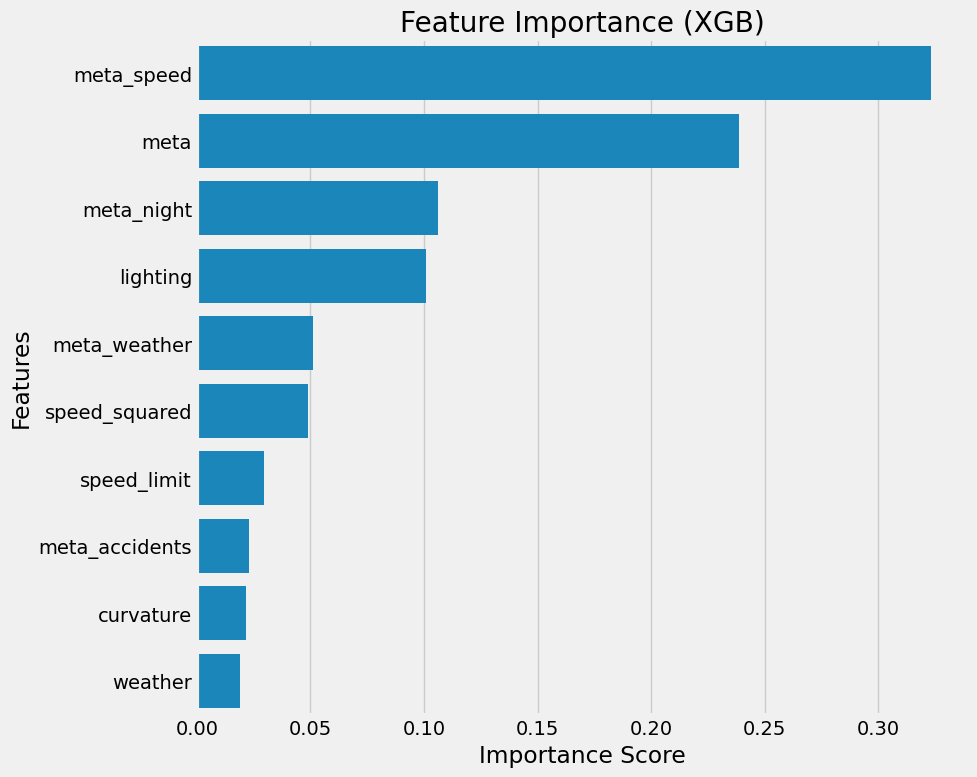

In [29]:
feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': feature_importances
})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', 
            y='feature', 
            data=importance_df.head(10)) 
plt.title('Feature Importance (XGB)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [30]:
df_sub['accident_risk'] = ensemble_pred

df_sub.to_csv('submission.csv', index=False)

df_sub.head()

,id,accident_risk
0,517754,0.294350
1,517755,0.120674
2,517756,0.181030
3,517757,0.312636
4,517758,0.398374
